In [1]:
import pandas as pd
df = pd.read_csv("advection_dataset.csv")
df = pd.read_csv(r"C:\Users\mpstme.student\Advection\advection_dataset.csv")  # Windows path
# Or for Linux/Mac:
# df = pd.read_csv("/home/aayesha/Documents/myfile.csv")
df.head()  # Shows first 5 rows


,t,r,theta,u(t),u(t+dt)
0,0.00,0.0,0.0,0.0,0.0
1,0.25,0.0,0.0,0.0,-0.0
2,0.50,0.0,0.0,-0.0,-0.0
3,0.75,0.0,0.0,-0.0,-0.0
4,1.00,0.0,0.0,-0.0,-0.0


In [2]:
import pandas as pd
df = pd.read_csv("advection_dataset.csv")
df = pd.read_csv(r"C:\Users\mpstme.student\Advection\advection_dataset.csv")  # Windows path
# Or for Linux/Mac:
# df = pd.read_csv("/home/aayesha/Documents/myfile.csv")
df  # Shows all rows

,t,r,theta,u(t),u(t+dt)
0,0.00,0.0,0.000000,0.000000e+00,0.000000e+00
1,0.25,0.0,0.000000,0.000000e+00,-0.000000e+00
2,0.50,0.0,0.000000,-0.000000e+00,-0.000000e+00
3,0.75,0.0,0.000000,-0.000000e+00,-0.000000e+00
4,1.00,0.0,0.000000,-0.000000e+00,-0.000000e+00
...,...,...,...,...,...
995,0.00,1.0,5.969026,-5.421814e-16,-4.817423e-16
996,0.25,1.0,5.969026,-4.817423e-16,-3.913507e-16
997,0.50,1.0,5.969026,-3.913507e-16,-2.766269e-16
998,0.75,1.0,5.969026,-2.766269e-16,-1.447038e-16


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.special import jn, jn_zeros

# ------------------------------
# Parameters
# ------------------------------
Nr, Ntheta, Nt = 20, 5, 10
r = np.linspace(1e-3, 1, Nr)
theta = np.linspace(0, 2 * np.pi, Ntheta)
t = np.linspace(0, 2 * np.pi, Nt)
R, Theta = np.meshgrid(r, theta, indexing='ij')
alpha = jn_zeros(1, 5)  # First 5 zeros of J1 (order n=1)
c = 1.0

# ------------------------------
# Import dataset from CSV
# ------------------------------
# Windows path
df = pd.read_csv(r"C:\Users\mpstme.student\Advection\advection_dataset.csv")
# After loading the CSV:
total_points = len(df)
print("Total data points:", total_points)

# Given Nt=10, guess Nr and Ntheta:
Nt = 10
NrNtheta = total_points // Nt
print("Nr * Ntheta =", NrNtheta)

# Try to pick factors of NrNtheta close to your expectations, e.g. 16, 16 = 256 (too small for 100)

# If you are flexible, try:
Nr = 20
Ntheta = NrNtheta // Nr  # Should be integer division

print(f"Assuming Nr={Nr}, then Ntheta={Ntheta}")

# Now reshape using these:
u_data = df["u(t)"].to_numpy().reshape(Nt, Nr, Ntheta)
print("New u_data shape:", u_data.shape)


# Ensure sorting by t, r, theta
df = df.sort_values(["t", "r", "theta"])


# Now reshape using these:
u_data = df["u(t)"].to_numpy().reshape(Nt, Nr, Ntheta)
print("New u_data shape:", u_data.shape)



# Extract u values and reshape to (Nt, Nr, Ntheta)
u_data = df["u(t)"].to_numpy().reshape(Nt, Nr, Ntheta)
print("Shape of u_data:", u_data.shape)

# ------------------------------
# Build Fourier–Bessel Basis
# ------------------------------
n_modes = 5
basis = np.zeros((n_modes, Nr, Ntheta))

for m in range(n_modes):
    Jm = jn(1, alpha[m] * R)
    basis[m] = Jm * np.cos(Theta)  # Cosine mode for θ

# ------------------------------
# Projection: u → coefficients
# ------------------------------
def project_to_basis(u_snap, basis):
    coeffs = np.zeros(len(basis))
    for i in range(len(basis)):
        coeffs[i] = np.sum(u_snap * basis[i]) / np.sum(basis[i] ** 2)
    return coeffs

coeff_data = np.zeros((Nt, n_modes))
for i in range(Nt):
    coeff_data[i] = project_to_basis(u_data[i], basis)

# ------------------------------
# Create training dataset (t → t+1)
# ------------------------------
X = coeff_data[:-1]
Y = coeff_data[1:]

X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)
dataset = TensorDataset(X_tensor, Y_tensor)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# ------------------------------
# Define Fourier–Bessel NN
# ------------------------------
class FourierBesselNN(nn.Module):
    def __init__(self, dim, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, dim)
        )
    def forward(self, x):
        return self.net(x)

model = FourierBesselNN(dim=n_modes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
# ------------------------------
# Train model
# ------------------------------
for epoch in range(10):
    total_loss = 0
    for xb, yb in loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss = {total_loss/len(loader):.6f}")

# ------------------------------
# Predict next time step
# ------------------------------
with torch.no_grad():
    coeff_pred = model(X_tensor[0:1]).numpy().flatten()

# ------------------------------
# Reconstruct solution u(r, θ, t+Δt)
# ------------------------------
u_recon = np.zeros((Nr, Ntheta))
for i in range(n_modes):
    u_recon += coeff_pred[i] * basis[i]


# save results ----------
torch.save(model.state_dict(), "fbnn_model.pth")
np.save("u_data.npy", u_data)
np.save("u_recon.npy", u_recon)

print("Training complete. Data saved.")

Total data points: 1000
Nr * Ntheta = 100
Assuming Nr=20, then Ntheta=5
New u_data shape: (10, 20, 5)
New u_data shape: (10, 20, 5)
Shape of u_data: (10, 20, 5)
Epoch 1, Loss = 0.014526
Epoch 2, Loss = 0.012055
Epoch 3, Loss = 0.009856
Epoch 4, Loss = 0.007915
Epoch 5, Loss = 0.006252
Epoch 6, Loss = 0.004834
Epoch 7, Loss = 0.003647
Epoch 8, Loss = 0.002682
Epoch 9, Loss = 0.001929
Epoch 10, Loss = 0.001380
Training complete. Data saved.


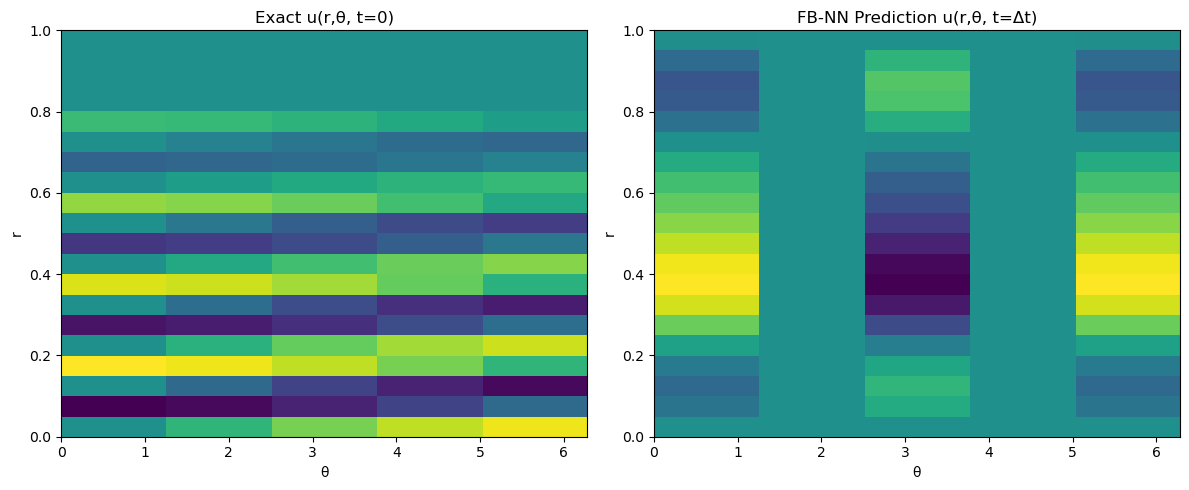

In [1]:
import numpy as np
import matplotlib.pyplot as plt

u_data = np.load("u_data.npy")
u_recon = np.load("u_recon.npy")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(u_data[0], extent=(0, 2*np.pi, 0, 1), aspect='auto')
plt.title("Exact u(r,θ, t=0)")
plt.xlabel("θ")
plt.ylabel("r")

plt.subplot(1, 2, 2)
plt.imshow(u_recon, extent=(0, 2*np.pi, 0, 1), aspect='auto')
plt.title("FB-NN Prediction u(r,θ, t=Δt)")
plt.xlabel("θ")
plt.ylabel("r")

plt.tight_layout()
plt.show()

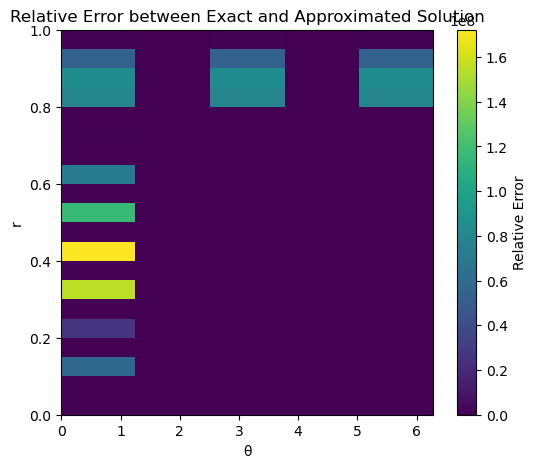

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose u_data and u_recon have shape (Nr, Ntheta) or (Nt, Nr, Ntheta)
# Let's take one time snapshot, e.g. t=0

exact = u_data[0]
approx = u_recon

# Small epsilon to avoid division by zero
epsilon = 1e-10

relative_error = np.abs(exact - approx) / (np.abs(exact) + epsilon)

plt.figure(figsize=(6,5))
im = plt.imshow(relative_error, extent=(0, 2*np.pi, 0, 1), aspect='auto', cmap='viridis')
plt.colorbar(im, label="Relative Error")
plt.title("Relative Error between Exact and Approximated Solution")
plt.xlabel("θ")
plt.ylabel("r")
plt.show()


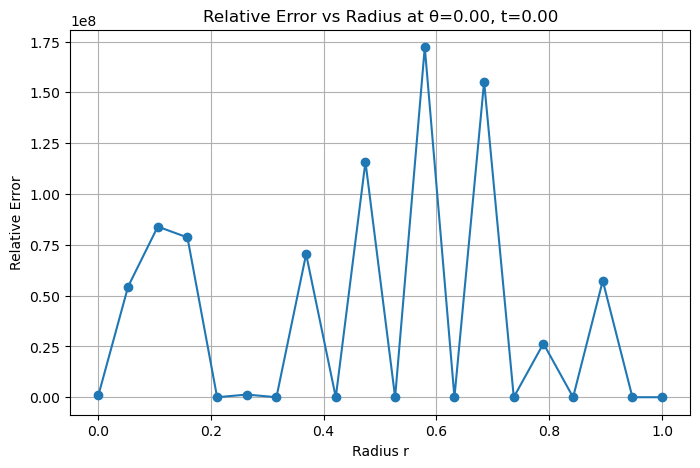

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming u_data and u_recon already loaded

time_idx = 0
theta_idx = 0

Nr = u_data.shape[1]
Ntheta = u_data.shape[2]

r = np.linspace(1e-3, 1, Nr)
theta = np.linspace(0, 2 * np.pi, Ntheta)
t = np.linspace(0, 2 * np.pi, u_data.shape[0])  # time vector

exact = u_data[time_idx, :, theta_idx]
approx = u_recon[:, theta_idx]

epsilon = 1e-10
relative_error = np.abs(exact - approx) / (np.abs(exact) + epsilon)

plt.figure(figsize=(8,5))
plt.plot(r, relative_error, marker='o')
plt.xlabel("Radius r")
plt.ylabel("Relative Error")
plt.title(f"Relative Error vs Radius at θ={theta[theta_idx]:.2f}, t={t[time_idx]:.2f}")
plt.grid(True)
plt.show()



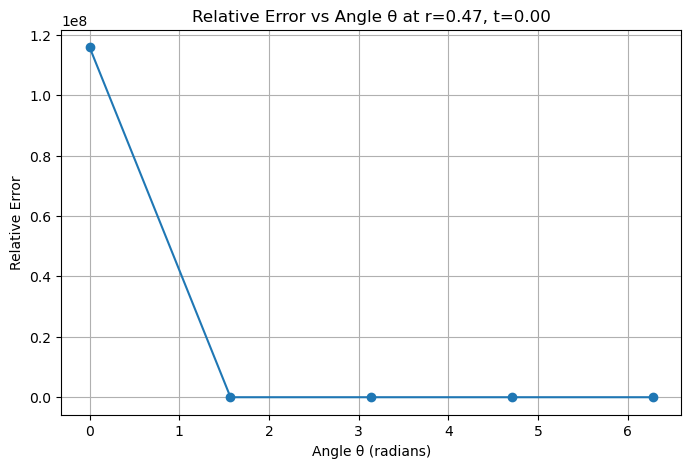

In [5]:
# Find index closest to r=0.5
r_val = 0.5
r_idx = np.abs(r - r_val).argmin()
time_idx = 0

exact = u_data[time_idx, r_idx, :]
approx = u_recon[r_idx, :]

relative_error = np.abs(exact - approx) / (np.abs(exact) + epsilon)

plt.figure(figsize=(8,5))
plt.plot(theta, relative_error, marker='o')
plt.xlabel("Angle θ (radians)")
plt.ylabel("Relative Error")
plt.title(f"Relative Error vs Angle θ at r={r[r_idx]:.2f}, t={t[time_idx]:.2f}")
plt.grid(True)
plt.show()


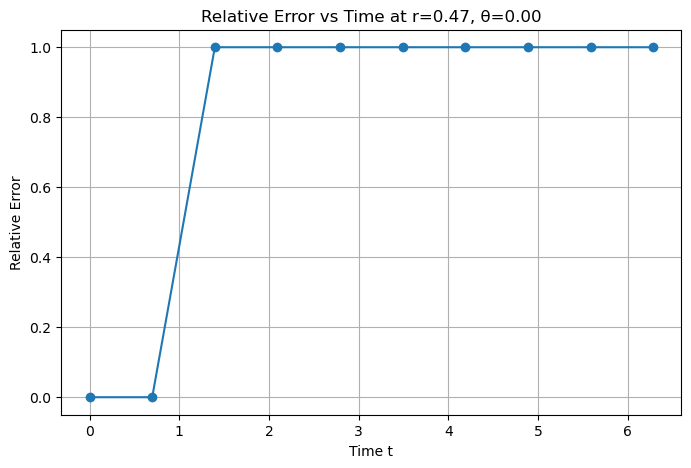

In [6]:
r_idx = np.abs(r - 0.5).argmin()
theta_idx = 0

# For this, you need u_recon at multiple times, or predicted coeffs at each time step.
# Let's assume you have arrays u_data and u_pred both shape (Nt, Nr, Ntheta)

u_pred = np.zeros_like(u_data)  # Replace with your predicted data for all time steps

epsilon = 1e-10
relative_error = np.abs(u_data[:, r_idx, theta_idx] - u_pred[:, r_idx, theta_idx]) / \
                 (np.abs(u_data[:, r_idx, theta_idx]) + epsilon)

plt.figure(figsize=(8,5))
plt.plot(t, relative_error, marker='o')
plt.xlabel("Time t")
plt.ylabel("Relative Error")
plt.title(f"Relative Error vs Time at r={r[r_idx]:.2f}, θ={theta[theta_idx]:.2f}")
plt.grid(True)
plt.show()
